<a href="https://colab.research.google.com/github/FranciscoGlez25/CNN-TC/blob/main/ResNet50_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Configuración del Entorno y Dispositivo de GPU**

En este bloque de código, se realiza la configuración inicial del entorno para trabajar con PyTorch y se verifica la disponibilidad de la GPU.

1. **Importación de Librerías:**
   - Importa las librerías necesarias, incluyendo PyTorch, torchvision, pandas, PIL (Pillow), os, tqdm, matplotlib, seaborn y otras.

2. **Verificación de la GPU:**
   - Utiliza `torch.cuda.is_available()` para verificar si una GPU está disponible.
   - Configura el dispositivo (`device`) en "cuda" si hay una GPU disponible; de lo contrario, usa "cpu".

Este bloque establece el entorno y el dispositivo necesario para trabajar con modelos de PyTorch en una GPU si está disponible, de lo contrario, utilizará la CPU.[texto del vínculo](https://)

In [ ]:
import torch
import torchvision
from torchvision.transforms import v2
import torch.optim as optim
import torch.nn as nn
import torch.nn.init as init
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from PIL import Image
import os
from tqdm import tqdm_notebook as tqdm
import matplotlib.image as img
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import torchvision.models as models
from torch.nn import Linear, CrossEntropyLoss, Sequential

torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/opt/conda/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

# **Realizar transformaciones adecuadas para el modelo**

En este bloque de código, se definen las transformaciones que se aplicarán a las imágenes durante el preprocesamiento.

1. **Transformaciones de Entrenamiento (`transform_train`):**
   - `ToTensor()`: Convierte la imagen a un tensor.
   - `CenterCrop(size=(850, 850))`: Realiza un recorte centrado de la imagen a un tamaño de 850x850 píxeles.
   - `Resize(size=(224, 224))`: Cambia el tamaño de la imagen a 224x224 píxeles.
   - `RandomHorizontalFlip(p=0.5)`: Aplica una posibilidad del 50% de voltear horizontalmente la imagen de manera aleatoria.
   - `Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])`: Normaliza la imagen con medias y desviaciones estándar predefinidas.

2. **Transformaciones de Prueba (`transform_test`):**
   - Similar a las transformaciones de entrenamiento, pero sin la operación de volteo horizontal.

Estas transformaciones se utilizan para preparar las imágenes antes de alimentarlas al modelo. La normalización es particularmente importante para garantizar que los datos tengan una escala y distribución consistentes. La operación de volteo horizontal durante el entrenamiento introduce variedad en el conjunto de datos para mejorar la capacidad del modelo para generalizar.

In [ ]:
from torchvision import datasets, transforms, models

# Definir transformaciones para el preprocesamiento de las imágenes
transform_train = v2.Compose([v2.ToTensor(),
                    v2.CenterCrop(size = (850, 850)),
                    v2.Resize(size = (224, 224)),
                    v2.RandomHorizontalFlip(p=0.5),
                    #v2.RandomEqualize(p = 1),
                    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ])

transform_test = v2.Compose([v2.ToTensor(),
                    v2.CenterCrop(size = (850, 850)),
                    v2.Resize(size = (224, 224)),
                    #v2.RandomEqualize(p = 1),
                    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ])

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


# **Definir la clase CustomDataset para obtener las etiquetas del archivo .csv y las imágenes**

En este bloque de código, se define una clase `CustomDataset` que hereda de la clase `Dataset` de PyTorch.

- **Método `__init__`:**
  - Recibe como entrada la ruta del archivo CSV (`csv_file`), la carpeta raíz de las imágenes (`root_dir`), y las transformaciones a aplicar (`transform`).
  - Lee el archivo CSV con etiquetas y otras anotaciones.
  - Almacena el DataFrame resultante y las otras variables de entrada como atributos de la clase.
  - Calcula el número de clases únicas en la columna 'Egreso' del conjunto de datos y lo almacena como `self.num_classes`.

- **Método `__len__`:**
  - Devuelve la longitud total del conjunto de datos, es decir, el número de filas en el DataFrame.

- **Método `__getitem__`:**
  - Recibe un índice como entrada.
  - Construye la ruta de la imagen correspondiente utilizando la carpeta raíz y la información del DataFrame.
  - Abre la imagen en formato RGB usando `PIL.Image`.
  - Obtiene la etiqueta correspondiente del DataFrame.
  - Aplica transformaciones a la imagen si se proporcionan.
  - Devuelve la imagen y su etiqueta como una tupla.

Este conjunto de datos personalizado es utilizado para cargar imágenes y etiquetas desde un archivo CSV, proporcionando una interfaz compatible con PyTorch para integrar fácilmente con los dataloaders. La columna 'Egreso' se asume como la columna de etiquetas en el archivo CSV.

In [ ]:
# Definir dataset personalizado para cargar imágenes y clases desde archivos CSV
class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

        # Obtener el número de clases desde el conjunto de datos
        self.num_classes = len(self.annotations['Egreso'].unique())  # Suponiendo que la columna de etiquetas se llama 'label'

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = Image.open(img_path).convert('RGB')
        label = self.annotations.iloc[index, 3]

        if self.transform:
            image = self.transform(image)

        return image, label

# **Montaje de Google Drive en Colab**


En este bloque de código, se utiliza la biblioteca `google.colab` para montar Google Drive en el entorno de ejecución de Google Colab. Google Drive es una plataforma de almacenamiento en la nube, y montarlo en Colab permite acceder y manipular archivos almacenados en Google Drive directamente desde el entorno de ejecución.

1. **Importación de la Biblioteca:**
   Se importa la biblioteca `drive` desde `google.colab`.

2. **Montaje de Google Drive:**
   La función `drive.mount('/content/drive')` se utiliza para montar Google Drive en el directorio `/content/drive` de Colab. Al ejecutar esta celda, aparecerá un enlace para autorizar el acceso a Google Drive. Después de la autorización, se generará un código de autenticación que debe ser copiado y pegado en un campo de entrada en la celda para completar el proceso de montaje.

Este bloque es esencial cuando se trabaja con archivos almacenados en Google Drive desde un entorno de ejecución en Google Colab. Una vez montado, se pueden acceder a los archivos de Google Drive como si fueran archivos locales en la ruta `/content/drive`.

In [ ]:
from google.colab import drive

# Monta Google Drive en el entorno de ejecución
drive.mount('/content/drive')

# **Creación del Conjunto de Datos y DataLoader**

En este bloque de código, se crea el conjunto de datos de entrenamiento (`train_dataset`) utilizando la clase `CustomDataset` definida previamente. También se imprime la cantidad total de imágenes en el conjunto de entrenamiento.

- Se instancia `CustomDataset` con la ruta al archivo CSV (`'ruta_archivo_csv'`), la carpeta raíz de las imágenes (`'ruta_carpeta_imagenes'`), y las transformaciones de entrenamiento (`transform_train`).
  
- La variable `total_train` se establece como la longitud total del conjunto de entrenamiento utilizando la función `len(train_dataset)`.

- Finalmente, se imprime la cantidad total de imágenes en el conjunto de entrenamiento.

Este bloque es esencial para preparar los datos de entrenamiento antes de pasarlos al modelo de red neuronal para el entrenamiento.

In [ ]:
from torch.utils.data import DataLoader, random_split

# Define el conjunto de datos completo
train_dataset = CustomDataset('ruta_archivo_csv', 'ruta_carpeta_imagenes', transform=transform_train)

total_train = len(train_dataset)
print(f'Cantidad total de imágenes en Train Dataset: {total_train}')

Cantidad total de imágenes en Train Dataset: 964


# **División del Conjunto de Datos y Creación de DataLoaders**

En este bloque, se realiza la división del conjunto de datos de entrenamiento en conjuntos de entrenamiento y validación, además de la creación de DataLoaders correspondientes.

- `total_samples`: Se obtiene el número total de muestras en el conjunto de entrenamiento.

- `validation_split`: Especifica la fracción del conjunto de entrenamiento que se utilizará como conjunto de validación (por ejemplo, 20%).

- `validation_size`: Se calcula el tamaño del conjunto de validación multiplicando `validation_split` por el número total de muestras en el conjunto de entrenamiento.

- `train_size`: Representa el tamaño del conjunto de entrenamiento y se calcula restando `validation_size` de `total_samples`.

- `train_dataset, validation_dataset`: Utilizando la función `random_split` del módulo `torch.utils.data`, se divide el conjunto de entrenamiento en un conjunto de entrenamiento y uno de validación.

- `train_loader, val_loader`: Se crean DataLoaders para el conjunto de entrenamiento y el conjunto de validación, respectivamente, utilizando la clase `DataLoader` de PyTorch. Estos DataLoaders se utilizan para iterar sobre los datos durante el entrenamiento y la validación.

Este bloque es fundamental para establecer la configuración del entrenamiento, dividiendo el conjunto de datos en partes para el entrenamiento y la evaluación del modelo.

In [ ]:
# Obtén el número total de muestras en el conjunto de entrenamiento
total_samples = len(train_dataset)

# Calcula el número de muestras para el conjunto de validación (por ejemplo, el 20%)
validation_split = 0.2
validation_size = int(validation_split * total_samples)

# Calcula el tamaño del conjunto de entrenamiento
train_size = total_samples - validation_size

# Divide el conjunto de entrenamiento en conjunto de entrenamiento y conjunto de validación
train_dataset, validation_dataset = random_split(train_dataset, [train_size, validation_size])

# Define los DataLoaders para entrenamiento y validación
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=64, shuffle=True)

**Cantidad Total de Imágenes en Train y Validation Dataset Después de la División:**

En este bloque, se calcula y muestra la cantidad total de imágenes en los conjuntos de entrenamiento y validación después de realizar la división. Aquí está el resumen del bloque:

- `total_images_train`: Se obtiene la cantidad total de imágenes en el conjunto de entrenamiento utilizando la propiedad `dataset` del `train_loader`.

- `total_images_validation`: Se obtiene la cantidad total de imágenes en el conjunto de validación utilizando la propiedad `dataset` del `val_loader`.

- Se imprime la cantidad total de imágenes en el conjunto de entrenamiento y en el conjunto de validación después de realizar la división.

Este bloque proporciona información sobre la cantidad de datos disponibles para el entrenamiento y la validación después de la división del conjunto de datos. Es útil para verificar que la división se realizó correctamente y entender el tamaño de los conjuntos de datos utilizados en cada fase del entrenamiento.

In [ ]:
# Obtén la cantidad total de imágenes en train_loader y validation_loader
total_images_train = len(train_loader.dataset)
total_images_validation = len(val_loader.dataset)

# Imprime la cantidad total de imágenes
print(f'Cantidad total de imágenes en Train Dataset despues de realizar split: {total_images_train}')
print(f'Cantidad total de imágenes en Validation Dataset: {total_images_validation}')

Cantidad total de imágenes en Train Dataset despues de realizar split: 772
Cantidad total de imágenes en Validation Dataset: 192


# **Definición del Dataset de Prueba y DataLoader**

En este bloque, se define el dataset de prueba (`test_dataset`) utilizando la clase `CustomDataset` y se crea un DataLoader (`test_loader`) para cargar los datos de prueba.

- `test_dataset`: Se crea un objeto `CustomDataset` para el conjunto de prueba, utilizando la ruta al archivo CSV y la carpeta de imágenes, junto con la transformación `transform_test`.

- `test_loader`: Se crea un DataLoader para el conjunto de prueba (`test_dataset`) con un tamaño de lote de 64 y el parámetro `shuffle` configurado en `True`.

- `total_images_test`: Se obtiene la cantidad total de imágenes en el conjunto de prueba utilizando la propiedad `dataset` del `test_loader`.

- Se imprime la cantidad total de imágenes en el conjunto de prueba.

Este bloque se encarga de preparar el conjunto de datos de prueba para su uso durante la evaluación del modelo. El DataLoader facilita la iteración a través del conjunto de datos de prueba en mini lotes durante la evaluación del modelo.

In [ ]:
# Definir dataset de validación y dataloader
test_dataset = CustomDataset('ruta_archivo_csv', 'ruta_carpeta_imagenes', transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

total_images_test = len(test_loader.dataset)
print(f'Cantidad total de imágenes en Test Dataset: {total_images_test}')

Cantidad total de imágenes en Test Dataset: 240


# **Obtención del Número de Clases en el Conjunto de Prueba**

En este bloque, se obtiene el número de clases presente en el conjunto de prueba (`test_dataset`) mediante la propiedad `num_classes` de la instancia del dataset.

- `num_classes`: Se obtiene el número de clases en el conjunto de prueba accediendo a la propiedad `num_classes` de la instancia `test_dataset`.

- Se imprime el número de clases en el conjunto de prueba.

Este bloque proporciona información sobre la cantidad de clases presentes en el conjunto de datos de prueba. Es importante conocer el número de clases, ya que es un factor crucial en la configuración de la capa de salida del modelo y en la interpretación de los resultados durante la evaluación.

In [ ]:
num_classes = test_dataset.num_classes
print("Clases obtenidas en el conjunto Test Dataset:", num_classes)

Clases obtenidas en el conjunto Test Dataset: 2


# **Carga del Modelo ResNet50 y Modificación de la Capa de Clasificación**


En este bloque, se carga el modelo ResNet50 preentrenado y se modifica la capa de clasificación para adaptarse a dos clases.

- `model`: Se carga el modelo ResNet50 preentrenado desde `torchvision.models` con `pretrained=True`.

- `num_features`: Se obtiene el número de características en la capa de entrada de la clasificación original del modelo ResNet50.

- Se modifica la capa de clasificación (`model.fc`) para tener una capa lineal (`nn.Linear`) con el número correcto de características de entrada (`num_features`) y el número de clases correcto (`num_classes`).

- El modelo se mueve al dispositivo de entrenamiento (`cuda:0` si está disponible; de lo contrario, `cpu`).

Este bloque es esencial para adaptar la arquitectura del modelo a la tarea específica de dos clases. La capa de clasificación se redefine para tener el número correcto de neuronas de salida para las clases deseadas.

In [ ]:
model = models.resnet50(pretrained=True)
# Modificar la capa de clasificación para dos clases
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes) # Dos clases

# Mover modelo a dispositivo de entrenamiento
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 229MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# **Visualizamos la arquitectura del modelo**

In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# **Definición de Función de Pérdida, Optimizador, y Especificación de Épocas**


En este bloque, se definen la función de pérdida y el optimizador, y se especifica el número de épocas para entrenar el modelo.

- `criterion`: Se define la función de pérdida como la entropía cruzada (`nn.CrossEntropyLoss`). La función de pérdida se mueve al dispositivo de entrenamiento (`device`).

- `optimizer`: Se define el optimizador Adam (`optim.Adam`) para ajustar los parámetros del modelo durante el entrenamiento. Se especifica una tasa de aprendizaje de 0.0001 y una penalización de peso (weight decay) de 1e-5.

- `epochs`: Se especifica el número de épocas para entrenar el modelo. En este caso, se ha establecido en 100 épocas.

Este bloque configura la optimización y la función de pérdida necesarias para el proceso de entrenamiento y establece el número de épocas para controlar cuántas veces se iterará sobre el conjunto de entrenamiento completo.

In [ ]:
# Definir función de pérdida y optimizador
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

# Entrenar modelo por 100 épocas
epochs = 100

# **Entrenamiento del Modelo ResNet50**



Este bloque de código realiza el entrenamiento del modelo ResNet50.

- `train_loss`: Lista para almacenar las pérdidas de entrenamiento.
- `train_accuracy`: Lista para almacenar la precisión de entrenamiento.
- `val_loss`: Lista para almacenar las pérdidas de validación.
- `val_accuracy`: Lista para almacenar la precisión de validación.
- `best_val_loss`: Variable para almacenar la mejor pérdida de validación inicializada como infinito.
- `best_epoch`: Variable para almacenar la mejor época inicializada como 0.

El bucle principal itera a través de las épocas especificadas (`epochs`). Para cada época, se realiza el siguiente proceso:

1. **Entrenamiento del Modelo:**
   - El modelo se coloca en el modo de entrenamiento (`model.train()`).
   - Se utiliza un iterador de progreso (`tqdm`) para mostrar una barra de progreso durante el entrenamiento.
   - Para cada lote en el conjunto de entrenamiento (`train_loader`):
      - Se lleva a cabo la propagación hacia adelante y hacia atrás para calcular y actualizar los gradientes.
      - Se registra la pérdida actual y se actualiza la barra de progreso.

2. **Validación del Modelo:**
   - Si la época es múltiplo de 1, se realiza la validación.
   - El modelo se coloca en el modo de evaluación (`model.eval()`).
   - Se realiza la validación en el conjunto de validación (`val_loader`).
   - Se calcula la precisión y la pérdida de validación.
   - Se actualiza la mejor pérdida de validación y se guarda el modelo si se encuentra una mejor pérdida.

3. **Almacenamiento de Resultados:**
   - Se almacenan las métricas de entrenamiento y validación en las listas correspondientes.

4. **Guardado del Mejor Modelo:**
   - Al final de las épocas, se guarda el modelo con la mejor pérdida de validación.

Este bloque representa el ciclo de entrenamiento y validación del modelo ResNet50 a lo largo de múltiples épocas.

In [ ]:
train_loss = []  # Lista para almacenar las pérdidas de entrenamiento
train_accuracy = []  # Lista para almacenar la precisión de entrenamiento
val_loss = []  # Lista para almacenar las pérdidas de validación
val_accuracy = []  # Lista para almacenar la precisión de validación
best_val_loss = float('inf')  # Inicializa la mejor pérdida de validación como infinito
best_epoch = 0  # Inicializa la mejor época como 0


for epoch in range(epochs):
    model.train()
    total = 0
    correct = 0
    counter = 0
    train_running_loss = 0

    # Utiliza tqdm para mostrar una barra de progreso durante el entrenamiento
    with tqdm(train_loader, unit="batch") as tepoch:  # Utiliza train_loader en lugar de train_dataset
        # Etiqueta de la barra de progreso
        tepoch.set_description(f'Epoch {epoch+1}/{epochs}')

        for images, labels in tepoch:  # Utiliza tepoch como iterable
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_running_loss += loss.item() * images.size(0)

            _, pred = torch.max(outputs.data, 1)

            # Lleva un registro de cuántas imágenes se han propagado hacia adelante
            total += labels.size(0)
            # Lleva un registro de cuántas se predijeron correctamente
            correct += (pred == labels).sum().item()

            # Actualiza la barra de progreso con la pérdida actual
            tepoch.set_postfix(loss=train_running_loss/total)  # Puedes mostrar la pérdida en la barra de progreso

        train_accuracy.append(correct/total)
        train_loss.append(train_running_loss/len(train_dataset))

        print(f'Epoch {epoch+1} Training Accuracy = {correct/total}')
        print(f'Epoch {epoch+1} Training Loss = {train_running_loss/len(train_dataset)}')

    # Obtén nuestra precisión y pérdida de validación
    if epoch %1 == 0:
        model.eval()
        total = 0
        correct = 0
        val_running_loss = 0

        # No necesitamos gradientes para la validación, así que envuélvelo en no_grad para ahorrar memoria
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                val_output = model(images)
                loss_val = criterion(val_output, labels)

                # Calcula la pérdida acumulada multiplicando el valor de pérdida por el tamaño del lote
                val_running_loss += loss_val.item() * images.size(0)
                _, pred = torch.max(val_output.data, 1)
                total += labels.size(0)
                correct += (pred == labels).sum().item()

            val_accuracy.append(correct/total)
            # Calcula la pérdida por época dividiendo la pérdida acumulada por el número de elementos en el conjunto de validación
            val_loss.append(val_running_loss/len(validation_dataset))

            # Actualiza la variable best_val_loss y guarda los pesos del modelo si la pérdida de validación actual es mejor.
            if val_loss[-1] < best_val_loss:
                best_val_loss = val_loss[-1]
                # Guarda los pesos del modelo en variables para almacenarlo al finalizar el entrenamiento.
                best_epoch = epoch
                best_model_name = "mejor_modelo.pth"
                best_model_dict = model.state_dict()
                #torch.save(model.state_dict(), best_model_name)
                best_model = model

            print(f'Epoch {epoch+1} Validation Accuracy = {correct/total}')
            print(f'Epoch {epoch+1} Validation Loss = {val_running_loss/len(validation_dataset)}')
            print(f"La mejor precisión de Validation Loss ({best_val_loss}) se alcanzó en la época {best_epoch + 1}")

            # Guarda los pesos del modelo en un archivo.
torch.save(best_model_dict, best_model_name)

/tmp/ipykernel_24/22504745.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  with tqdm(train_loader, unit="batch") as tepoch:  # Utiliza train_loader en lugar de train_dataset


  0%|          | 0/13 [00:00<?, ?batch/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 1 Training Accuracy = 0.7098445595854922
Epoch 1 Training Loss = 0.5402497016086479
Epoch 1 Validation Accuracy = 0.7552083333333334
Epoch 1 Validation Loss = 0.524841696023941
La mejor precisión de Validation Loss (0.524841696023941) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 2 Training Accuracy = 0.9183937823834197
Epoch 2 Training Loss = 0.2845906261644215
Epoch 2 Validation Accuracy = 0.7916666666666666
Epoch 2 Validation Loss = 0.5056414405504862
La mejor precisión de Validation Loss (0.5056414405504862) se alcanzó en la época 2


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 3 Training Accuracy = 0.9352331606217616
Epoch 3 Training Loss = 0.15769047317109577
Epoch 3 Validation Accuracy = 0.6979166666666666
Epoch 3 Validation Loss = 0.7685012022654215
La mejor precisión de Validation Loss (0.5056414405504862) se alcanzó en la época 2


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 4 Training Accuracy = 0.9455958549222798
Epoch 4 Training Loss = 0.15174145896200072
Epoch 4 Validation Accuracy = 0.703125
Epoch 4 Validation Loss = 0.93510502576828
La mejor precisión de Validation Loss (0.5056414405504862) se alcanzó en la época 2


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 5 Training Accuracy = 0.9430051813471503
Epoch 5 Training Loss = 0.17807937733867626
Epoch 5 Validation Accuracy = 0.7447916666666666
Epoch 5 Validation Loss = 0.6051208178202311
La mejor precisión de Validation Loss (0.5056414405504862) se alcanzó en la época 2


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 6 Training Accuracy = 0.9637305699481865
Epoch 6 Training Loss = 0.11002593707544198
Epoch 6 Validation Accuracy = 0.8125
Epoch 6 Validation Loss = 0.4767274558544159
La mejor precisión de Validation Loss (0.4767274558544159) se alcanzó en la época 6


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 7 Training Accuracy = 0.9637305699481865
Epoch 7 Training Loss = 0.1047109024203503
Epoch 7 Validation Accuracy = 0.875
Epoch 7 Validation Loss = 0.4590991735458374
La mejor precisión de Validation Loss (0.4590991735458374) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 8 Training Accuracy = 0.977979274611399
Epoch 8 Training Loss = 0.0677441081099714
Epoch 8 Validation Accuracy = 0.8333333333333334
Epoch 8 Validation Loss = 0.4430494010448456
La mejor precisión de Validation Loss (0.4430494010448456) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 9 Training Accuracy = 0.9922279792746114
Epoch 9 Training Loss = 0.031688922195854584
Epoch 9 Validation Accuracy = 0.8541666666666666
Epoch 9 Validation Loss = 0.41155492266019184
La mejor precisión de Validation Loss (0.41155492266019184) se alcanzó en la época 9


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 10 Training Accuracy = 0.9883419689119171
Epoch 10 Training Loss = 0.042913601391133246
Epoch 10 Validation Accuracy = 0.8697916666666666
Epoch 10 Validation Loss = 0.440960297981898
La mejor precisión de Validation Loss (0.41155492266019184) se alcanzó en la época 9


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 11 Training Accuracy = 0.9896373056994818
Epoch 11 Training Loss = 0.04211149535532751
Epoch 11 Validation Accuracy = 0.8072916666666666
Epoch 11 Validation Loss = 0.652817447980245
La mejor precisión de Validation Loss (0.41155492266019184) se alcanzó en la época 9


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 12 Training Accuracy = 0.9987046632124352
Epoch 12 Training Loss = 0.015407478156948337
Epoch 12 Validation Accuracy = 0.859375
Epoch 12 Validation Loss = 0.44924188653628033
La mejor precisión de Validation Loss (0.41155492266019184) se alcanzó en la época 9


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 13 Training Accuracy = 0.9974093264248705
Epoch 13 Training Loss = 0.008847973777531342
Epoch 13 Validation Accuracy = 0.8541666666666666
Epoch 13 Validation Loss = 0.4621828893820445
La mejor precisión de Validation Loss (0.41155492266019184) se alcanzó en la época 9


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 14 Training Accuracy = 0.9987046632124352
Epoch 14 Training Loss = 0.014372922499408376
Epoch 14 Validation Accuracy = 0.8645833333333334
Epoch 14 Validation Loss = 0.45025119185447693
La mejor precisión de Validation Loss (0.41155492266019184) se alcanzó en la época 9


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 15 Training Accuracy = 0.9689119170984456
Epoch 15 Training Loss = 0.0880775495668767
Epoch 15 Validation Accuracy = 0.8385416666666666
Epoch 15 Validation Loss = 0.46888352433840436
La mejor precisión de Validation Loss (0.41155492266019184) se alcanzó en la época 9


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 16 Training Accuracy = 0.961139896373057
Epoch 16 Training Loss = 0.10356457713856289
Epoch 16 Validation Accuracy = 0.75
Epoch 16 Validation Loss = 0.5740389426549276
La mejor precisión de Validation Loss (0.41155492266019184) se alcanzó en la época 9


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 17 Training Accuracy = 0.9650259067357513
Epoch 17 Training Loss = 0.10245417282371323
Epoch 17 Validation Accuracy = 0.8697916666666666
Epoch 17 Validation Loss = 0.3482085665067037
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 18 Training Accuracy = 0.9572538860103627
Epoch 18 Training Loss = 0.13270613319515565
Epoch 18 Validation Accuracy = 0.7760416666666666
Epoch 18 Validation Loss = 0.7285840312639872
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 19 Training Accuracy = 0.966321243523316
Epoch 19 Training Loss = 0.11257322674491708
Epoch 19 Validation Accuracy = 0.7760416666666666
Epoch 19 Validation Loss = 0.6001379092534384
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 20 Training Accuracy = 0.9805699481865285
Epoch 20 Training Loss = 0.06447271962162744
Epoch 20 Validation Accuracy = 0.7760416666666666
Epoch 20 Validation Loss = 0.628176212310791
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 21 Training Accuracy = 0.9948186528497409
Epoch 21 Training Loss = 0.026033395312610685
Epoch 21 Validation Accuracy = 0.8020833333333334
Epoch 21 Validation Loss = 0.5452436606089274
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 22 Training Accuracy = 0.9624352331606217
Epoch 22 Training Loss = 0.09763180561498812
Epoch 22 Validation Accuracy = 0.8125
Epoch 22 Validation Loss = 0.4312700231870015
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 23 Training Accuracy = 0.9805699481865285
Epoch 23 Training Loss = 0.06608036750145836
Epoch 23 Validation Accuracy = 0.8072916666666666
Epoch 23 Validation Loss = 0.6551776130994161
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 24 Training Accuracy = 0.9987046632124352
Epoch 24 Training Loss = 0.01970782208164739
Epoch 24 Validation Accuracy = 0.8177083333333334
Epoch 24 Validation Loss = 0.6091068436702093
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 25 Training Accuracy = 0.9844559585492227
Epoch 25 Training Loss = 0.04245459077966646
Epoch 25 Validation Accuracy = 0.7604166666666666
Epoch 25 Validation Loss = 0.8973631064097086
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 26 Training Accuracy = 0.9378238341968912
Epoch 26 Training Loss = 0.17614359404756616
Epoch 26 Validation Accuracy = 0.5729166666666666
Epoch 26 Validation Loss = 0.918410579363505
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 27 Training Accuracy = 0.9417098445595855
Epoch 27 Training Loss = 0.17222303913549128
Epoch 27 Validation Accuracy = 0.8125
Epoch 27 Validation Loss = 0.493059108654658
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 28 Training Accuracy = 0.9857512953367875
Epoch 28 Training Loss = 0.054032129558874535
Epoch 28 Validation Accuracy = 0.8385416666666666
Epoch 28 Validation Loss = 0.5670254429181417
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 29 Training Accuracy = 0.9948186528497409
Epoch 29 Training Loss = 0.026007222325343235
Epoch 29 Validation Accuracy = 0.8229166666666666
Epoch 29 Validation Loss = 0.5377756953239441
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 30 Training Accuracy = 0.9974093264248705
Epoch 30 Training Loss = 0.016620596150573284
Epoch 30 Validation Accuracy = 0.8645833333333334
Epoch 30 Validation Loss = 0.47789070506890613
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 31 Training Accuracy = 0.9987046632124352
Epoch 31 Training Loss = 0.00821695599096967
Epoch 31 Validation Accuracy = 0.8697916666666666
Epoch 31 Validation Loss = 0.3850126614173253
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 32 Training Accuracy = 0.9974093264248705
Epoch 32 Training Loss = 0.012993568544869596
Epoch 32 Validation Accuracy = 0.8125
Epoch 32 Validation Loss = 0.6019254227479299
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 33 Training Accuracy = 0.9481865284974094
Epoch 33 Training Loss = 0.15729748602435378
Epoch 33 Validation Accuracy = 0.796875
Epoch 33 Validation Loss = 0.5709551870822906
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 34 Training Accuracy = 0.9689119170984456
Epoch 34 Training Loss = 0.07873479937024684
Epoch 34 Validation Accuracy = 0.8385416666666666
Epoch 34 Validation Loss = 0.5007372200489044
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 35 Training Accuracy = 0.9637305699481865
Epoch 35 Training Loss = 0.12938747696887334
Epoch 35 Validation Accuracy = 0.7708333333333334
Epoch 35 Validation Loss = 0.8043353160222372
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 36 Training Accuracy = 0.977979274611399
Epoch 36 Training Loss = 0.0688630583855309
Epoch 36 Validation Accuracy = 0.8333333333333334
Epoch 36 Validation Loss = 0.48426292339960736
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 37 Training Accuracy = 0.9961139896373057
Epoch 37 Training Loss = 0.022065497471569735
Epoch 37 Validation Accuracy = 0.8541666666666666
Epoch 37 Validation Loss = 0.47496527433395386
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 38 Training Accuracy = 0.9766839378238342
Epoch 38 Training Loss = 0.06316324616806494
Epoch 38 Validation Accuracy = 0.8125
Epoch 38 Validation Loss = 0.7013370792071024
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 39 Training Accuracy = 0.9961139896373057
Epoch 39 Training Loss = 0.02345405132968191
Epoch 39 Validation Accuracy = 0.8072916666666666
Epoch 39 Validation Loss = 0.7919727166493734
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 40 Training Accuracy = 0.9844559585492227
Epoch 40 Training Loss = 0.06159867963951486
Epoch 40 Validation Accuracy = 0.7916666666666666
Epoch 40 Validation Loss = 0.754913330078125
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 41 Training Accuracy = 0.9805699481865285
Epoch 41 Training Loss = 0.06366822401476648
Epoch 41 Validation Accuracy = 0.8125
Epoch 41 Validation Loss = 0.5236628452936808
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 42 Training Accuracy = 0.9689119170984456
Epoch 42 Training Loss = 0.09201900251788797
Epoch 42 Validation Accuracy = 0.8020833333333334
Epoch 42 Validation Loss = 0.47442256410916644
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 43 Training Accuracy = 0.9507772020725389
Epoch 43 Training Loss = 0.15464639540163347
Epoch 43 Validation Accuracy = 0.7708333333333334
Epoch 43 Validation Loss = 0.679414709409078
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 44 Training Accuracy = 0.9365284974093264
Epoch 44 Training Loss = 0.1690913905133855
Epoch 44 Validation Accuracy = 0.7708333333333334
Epoch 44 Validation Loss = 0.5449893871943156
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 45 Training Accuracy = 0.9378238341968912
Epoch 45 Training Loss = 0.16107232864811014
Epoch 45 Validation Accuracy = 0.7708333333333334
Epoch 45 Validation Loss = 0.6377494136492411
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 46 Training Accuracy = 0.9766839378238342
Epoch 46 Training Loss = 0.0712479641709303
Epoch 46 Validation Accuracy = 0.796875
Epoch 46 Validation Loss = 0.588127871354421
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 47 Training Accuracy = 0.9922279792746114
Epoch 47 Training Loss = 0.036478506550771894
Epoch 47 Validation Accuracy = 0.8020833333333334
Epoch 47 Validation Loss = 0.48906630277633667
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 48 Training Accuracy = 0.9961139896373057
Epoch 48 Training Loss = 0.02185201728378707
Epoch 48 Validation Accuracy = 0.7864583333333334
Epoch 48 Validation Loss = 0.5692858099937439
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 49 Training Accuracy = 0.9974093264248705
Epoch 49 Training Loss = 0.014487329658140173
Epoch 49 Validation Accuracy = 0.8125
Epoch 49 Validation Loss = 0.5865468084812164
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 50 Training Accuracy = 1.0
Epoch 50 Training Loss = 0.007404831209137958
Epoch 50 Validation Accuracy = 0.8125
Epoch 50 Validation Loss = 0.5971083641052246
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 51 Training Accuracy = 0.9987046632124352
Epoch 51 Training Loss = 0.005496714939725214
Epoch 51 Validation Accuracy = 0.8125
Epoch 51 Validation Loss = 0.5214901169141134
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 52 Training Accuracy = 1.0
Epoch 52 Training Loss = 0.003717739559671422
Epoch 52 Validation Accuracy = 0.7916666666666666
Epoch 52 Validation Loss = 0.645402709643046
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 53 Training Accuracy = 0.9948186528497409
Epoch 53 Training Loss = 0.03358181840088701
Epoch 53 Validation Accuracy = 0.7916666666666666
Epoch 53 Validation Loss = 0.9135138392448425
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 54 Training Accuracy = 0.9598445595854922
Epoch 54 Training Loss = 0.1184162089475696
Epoch 54 Validation Accuracy = 0.7916666666666666
Epoch 54 Validation Loss = 0.7222733100255331
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 55 Training Accuracy = 0.9766839378238342
Epoch 55 Training Loss = 0.09365260436976512
Epoch 55 Validation Accuracy = 0.7864583333333334
Epoch 55 Validation Loss = 0.5457143584887186
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 56 Training Accuracy = 0.9909326424870466
Epoch 56 Training Loss = 0.033983644194553554
Epoch 56 Validation Accuracy = 0.8385416666666666
Epoch 56 Validation Loss = 0.49752060572306317
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 57 Training Accuracy = 0.9844559585492227
Epoch 57 Training Loss = 0.056827286017064604
Epoch 57 Validation Accuracy = 0.8333333333333334
Epoch 57 Validation Loss = 0.500496377547582
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 58 Training Accuracy = 0.9974093264248705
Epoch 58 Training Loss = 0.01814261858153683
Epoch 58 Validation Accuracy = 0.8541666666666666
Epoch 58 Validation Loss = 0.47172940770785016
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 59 Training Accuracy = 0.9987046632124352
Epoch 59 Training Loss = 0.013796910103120952
Epoch 59 Validation Accuracy = 0.8333333333333334
Epoch 59 Validation Loss = 0.47916380564371747
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 60 Training Accuracy = 0.9948186528497409
Epoch 60 Training Loss = 0.01233078628160793
Epoch 60 Validation Accuracy = 0.8489583333333334
Epoch 60 Validation Loss = 0.49995189905166626
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 61 Training Accuracy = 1.0
Epoch 61 Training Loss = 0.0067149130096707315
Epoch 61 Validation Accuracy = 0.8385416666666666
Epoch 61 Validation Loss = 0.45068594813346863
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 62 Training Accuracy = 0.9987046632124352
Epoch 62 Training Loss = 0.009570505788520828
Epoch 62 Validation Accuracy = 0.84375
Epoch 62 Validation Loss = 0.48921125133832294
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 63 Training Accuracy = 0.9948186528497409
Epoch 63 Training Loss = 0.018489197610727863
Epoch 63 Validation Accuracy = 0.8125
Epoch 63 Validation Loss = 0.6972588996092478
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 64 Training Accuracy = 0.9922279792746114
Epoch 64 Training Loss = 0.03008752161096492
Epoch 64 Validation Accuracy = 0.8489583333333334
Epoch 64 Validation Loss = 0.49595641096433
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 65 Training Accuracy = 0.9987046632124352
Epoch 65 Training Loss = 0.013112678506213766
Epoch 65 Validation Accuracy = 0.8541666666666666
Epoch 65 Validation Loss = 0.45913881063461304
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 66 Training Accuracy = 0.9987046632124352
Epoch 66 Training Loss = 0.009077381168931259
Epoch 66 Validation Accuracy = 0.8697916666666666
Epoch 66 Validation Loss = 0.42969738443692523
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 67 Training Accuracy = 0.9974093264248705
Epoch 67 Training Loss = 0.007780248130348371
Epoch 67 Validation Accuracy = 0.8697916666666666
Epoch 67 Validation Loss = 0.38556702931722003
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 68 Training Accuracy = 1.0
Epoch 68 Training Loss = 0.005716629427679153
Epoch 68 Validation Accuracy = 0.8541666666666666
Epoch 68 Validation Loss = 0.4134642481803894
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 69 Training Accuracy = 0.9961139896373057
Epoch 69 Training Loss = 0.01527399423054463
Epoch 69 Validation Accuracy = 0.8385416666666666
Epoch 69 Validation Loss = 0.48863192399342853
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 70 Training Accuracy = 0.9585492227979274
Epoch 70 Training Loss = 0.1086801768044116
Epoch 70 Validation Accuracy = 0.71875
Epoch 70 Validation Loss = 1.106460452079773
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 71 Training Accuracy = 0.9533678756476683
Epoch 71 Training Loss = 0.13099198112833685
Epoch 71 Validation Accuracy = 0.8072916666666666
Epoch 71 Validation Loss = 0.883306622505188
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 72 Training Accuracy = 0.961139896373057
Epoch 72 Training Loss = 0.10972459668322548
Epoch 72 Validation Accuracy = 0.796875
Epoch 72 Validation Loss = 0.9374080896377563
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 73 Training Accuracy = 0.9805699481865285
Epoch 73 Training Loss = 0.07042710019825654
Epoch 73 Validation Accuracy = 0.7760416666666666
Epoch 73 Validation Loss = 0.7165586054325104
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 74 Training Accuracy = 0.9883419689119171
Epoch 74 Training Loss = 0.06770782774902996
Epoch 74 Validation Accuracy = 0.8229166666666666
Epoch 74 Validation Loss = 0.6792574326197306
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 75 Training Accuracy = 0.9909326424870466
Epoch 75 Training Loss = 0.03870678685335298
Epoch 75 Validation Accuracy = 0.7760416666666666
Epoch 75 Validation Loss = 0.7164791723092397
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 76 Training Accuracy = 0.9740932642487047
Epoch 76 Training Loss = 0.07249591866305455
Epoch 76 Validation Accuracy = 0.7447916666666666
Epoch 76 Validation Loss = 0.8501614530881246
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 77 Training Accuracy = 0.9753886010362695
Epoch 77 Training Loss = 0.08387703313419856
Epoch 77 Validation Accuracy = 0.7864583333333334
Epoch 77 Validation Loss = 0.5723493496576945
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 78 Training Accuracy = 0.9922279792746114
Epoch 78 Training Loss = 0.046840254892957026
Epoch 78 Validation Accuracy = 0.8020833333333334
Epoch 78 Validation Loss = 0.5517790218194326
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 79 Training Accuracy = 0.9922279792746114
Epoch 79 Training Loss = 0.03575071692466736
Epoch 79 Validation Accuracy = 0.78125
Epoch 79 Validation Loss = 0.7329196333885193
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 80 Training Accuracy = 0.9805699481865285
Epoch 80 Training Loss = 0.05922459482837835
Epoch 80 Validation Accuracy = 0.7864583333333334
Epoch 80 Validation Loss = 0.6998212337493896
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 81 Training Accuracy = 0.9844559585492227
Epoch 81 Training Loss = 0.04675596222821913
Epoch 81 Validation Accuracy = 0.7916666666666666
Epoch 81 Validation Loss = 0.6518437365690867
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 82 Training Accuracy = 0.9922279792746114
Epoch 82 Training Loss = 0.03382121170316026
Epoch 82 Validation Accuracy = 0.7864583333333334
Epoch 82 Validation Loss = 0.7320815523465475
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 83 Training Accuracy = 0.9935233160621761
Epoch 83 Training Loss = 0.023006595980009266
Epoch 83 Validation Accuracy = 0.7864583333333334
Epoch 83 Validation Loss = 0.6786190668741862
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 84 Training Accuracy = 1.0
Epoch 84 Training Loss = 0.005701244627777004
Epoch 84 Validation Accuracy = 0.8072916666666666
Epoch 84 Validation Loss = 0.6998841563860575
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 85 Training Accuracy = 1.0
Epoch 85 Training Loss = 0.006566236625604061
Epoch 85 Validation Accuracy = 0.8125
Epoch 85 Validation Loss = 0.6959799329439799
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 86 Training Accuracy = 0.9987046632124352
Epoch 86 Training Loss = 0.006937155731678627
Epoch 86 Validation Accuracy = 0.78125
Epoch 86 Validation Loss = 0.6802228093147278
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 87 Training Accuracy = 0.9922279792746114
Epoch 87 Training Loss = 0.023946869191882523
Epoch 87 Validation Accuracy = 0.7864583333333334
Epoch 87 Validation Loss = 0.8085905512173971
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 88 Training Accuracy = 0.9974093264248705
Epoch 88 Training Loss = 0.013681552783040802
Epoch 88 Validation Accuracy = 0.78125
Epoch 88 Validation Loss = 0.7382778724034628
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 89 Training Accuracy = 0.9935233160621761
Epoch 89 Training Loss = 0.021037593406716775
Epoch 89 Validation Accuracy = 0.7604166666666666
Epoch 89 Validation Loss = 0.9161428014437357
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 90 Training Accuracy = 0.9831606217616581
Epoch 90 Training Loss = 0.05051858333262755
Epoch 90 Validation Accuracy = 0.71875
Epoch 90 Validation Loss = 0.9735333919525146
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 91 Training Accuracy = 0.9792746113989638
Epoch 91 Training Loss = 0.05143043257952354
Epoch 91 Validation Accuracy = 0.8125
Epoch 91 Validation Loss = 0.6875622272491455
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 92 Training Accuracy = 0.9870466321243523
Epoch 92 Training Loss = 0.0476885658720209
Epoch 92 Validation Accuracy = 0.7760416666666666
Epoch 92 Validation Loss = 0.7443363666534424
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 93 Training Accuracy = 0.9935233160621761
Epoch 93 Training Loss = 0.022742694562272087
Epoch 93 Validation Accuracy = 0.8072916666666666
Epoch 93 Validation Loss = 0.7492301265398661
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 94 Training Accuracy = 0.9948186528497409
Epoch 94 Training Loss = 0.02713649295309047
Epoch 94 Validation Accuracy = 0.7864583333333334
Epoch 94 Validation Loss = 0.9176609317461649
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 95 Training Accuracy = 0.9689119170984456
Epoch 95 Training Loss = 0.07136819955598506
Epoch 95 Validation Accuracy = 0.8125
Epoch 95 Validation Loss = 0.8773939808209738
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 96 Training Accuracy = 0.9520725388601037
Epoch 96 Training Loss = 0.1258438441111016
Epoch 96 Validation Accuracy = 0.71875
Epoch 96 Validation Loss = 1.1242780884106953
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 97 Training Accuracy = 0.9702072538860104
Epoch 97 Training Loss = 0.08298885513463786
Epoch 97 Validation Accuracy = 0.7864583333333334
Epoch 97 Validation Loss = 0.7445273399353027
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 98 Training Accuracy = 0.9909326424870466
Epoch 98 Training Loss = 0.03625057133908716
Epoch 98 Validation Accuracy = 0.8072916666666666
Epoch 98 Validation Loss = 0.6003884971141815
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 99 Training Accuracy = 0.9948186528497409
Epoch 99 Training Loss = 0.030193751880541984
Epoch 99 Validation Accuracy = 0.8072916666666666
Epoch 99 Validation Loss = 0.5515102644761404
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 100 Training Accuracy = 0.9935233160621761
Epoch 100 Training Loss = 0.022065316109768467
Epoch 100 Validation Accuracy = 0.8177083333333334
Epoch 100 Validation Loss = 0.5610427757104238
La mejor precisión de Validation Loss (0.3482085665067037) se alcanzó en la época 17


# **Visualización de Pérdida y Precisión durante el Entrenamiento**

Este bloque de código genera una gráfica que muestra la pérdida y la precisión del modelo en el conjunto de entrenamiento y validación a lo largo de las épocas.

- `epoch_log`: Lista que contiene el número de épocas.
- Se crea una figura con dos subgráficos (uno para pérdida y otro para precisión) utilizando Matplotlib.
- Se establece un título general y etiquetas para los ejes x e y.
- Se crean líneas para las curvas de pérdida y precisión del entrenamiento, así como para las del conjunto de validación.
- Se configuran los ejes y leyendas para ambos subgráficos.
- Se ajusta el espaciado entre los subgráficos para mejorar la visualización.
- La gráfica se guarda como un archivo PDF y se muestra.

Este bloque proporciona una representación visual del rendimiento del modelo a lo largo de las épocas, lo que facilita la interpretación de su entrenamiento y validación.

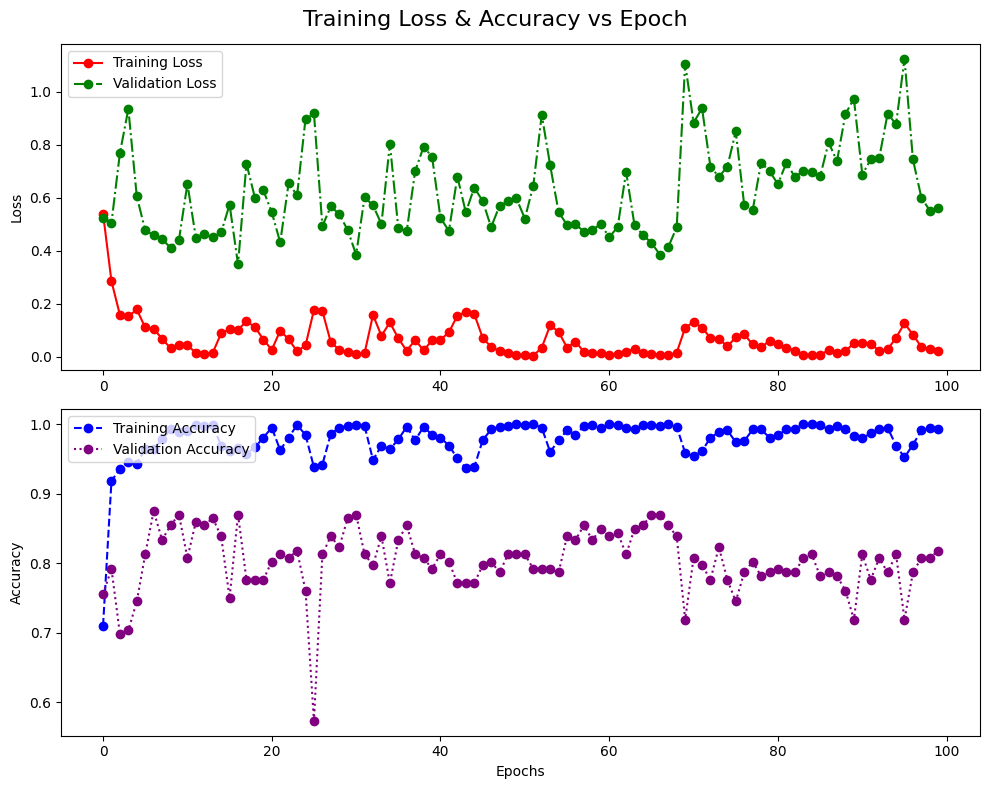

In [ ]:
epoch_log = [*range(epochs)]

# Crear la figura y los ejes
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))  # 2 filas, 1 columna

# Título y rotación del eje x
fig.suptitle("Training Loss & Accuracy vs Epoch", fontsize=16)
ax2.set_xlabel('Epochs')

# Crear las líneas para los datos de entrenamiento (colores y estilos personalizados)
ax1.plot(epoch_log, train_loss, color='red', linestyle='-', marker='o', label='Training Loss')
ax2.plot(epoch_log, train_accuracy, color='blue', linestyle='--', marker='o', label='Training Accuracy')

# Crear las líneas para los datos de validación (colores y estilos personalizados)
ax1.plot(epoch_log, val_loss, color='green', linestyle='-.', marker='o', label='Validation Loss')
ax2.plot(epoch_log, val_accuracy, color='purple', linestyle=':', marker='o', label='Validation Accuracy')

# Configurar ejes y leyendas para el primer subgráfico (pérdida)
ax1.set_ylabel('Loss', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.legend(loc='upper left')

# Configurar ejes y leyendas para el segundo subgráfico (precisión)
ax2.set_ylabel('Accuracy', color='black')
ax2.tick_params(axis='y', labelcolor='black')
ax2.legend(loc='upper left')

# Ajustar el espaciado entre los subgráficos
plt.tight_layout()

    # Nombre del archivo PDF
pdf_filename = "graficaFold2_Loss&AccvsEpoch.pdf"

    # Guardar la gráfica en un archivo PDF
plt.savefig(pdf_filename, format='pdf')

# Mostrar la gráfica
plt.show()

# **Evaluación del Modelo en el Conjunto de Prueba**

Este bloque de código realiza la evaluación final del modelo en el conjunto de prueba y calcula diversas métricas de rendimiento, incluyendo la precisión, recall y F1-score.

- `all_predictions` y `all_labels`: Listas para almacenar las predicciones del modelo y las etiquetas reales en el conjunto de prueba.
- Se inicializa un modelo ResNet50 sin pesos preentrenados y se modifica la capa de clasificación para dos clases.
- Se cargan los pesos entrenados desde el archivo ("mejor_modelo.pth").
- Se mueve el modelo al dispositivo de evaluación (GPU si está disponible).
- Se establece el modelo en modo de evaluación.
- Se inicializan variables para las métricas, incluyendo el número total de predicciones correctas y el número total de muestras en el conjunto de prueba.
- Se inicializa una matriz de confusión.
- Se realiza un bucle de prueba sobre el conjunto de prueba, sin realizar cálculos de gradiente.
- Se almacenan las predicciones y etiquetas reales para cálculos posteriores.
- Se calculan las métricas finales, incluyendo la precisión, recall y F1-score.

Este bloque proporciona una evaluación cuantitativa del rendimiento del modelo en datos no vistos, permitiendo una comprensión más completa de su capacidad para generalizar.

In [ ]:
# Inicializa listas para almacenar las predicciones y etiquetas reales
all_predictions = []
all_labels = []

model = models.resnet50(pretrained=False)
# Modificar la capa de clasificación para dos clases
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes) # Dos clases
# Cargar los pesos entrenados desde el archivo

model.load_state_dict(torch.load('mejor_modelo.pth'))

model.to(device)

# Cambiar el modelo a modo de evaluación
model.eval()

# Inicializa variables para las métricas
total_correct = 0
total_samples = 0

# Inicializa la matriz de confusión
confusion = torch.zeros(num_classes, num_classes)

# Realiza el bucle de prueba
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Realiza predicciones
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)

        # Calcula la matriz de confusión
        for t, p in zip(labels.view(-1), predictions.view(-1)):
            confusion[t.long(), p.long()] += 1

        # Calcula las métricas
        total_samples += labels.size(0)
        total_correct += (predictions == labels).sum().item()

        # Almacena las predicciones y etiquetas reales para cálculos posteriores
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calcula métricas finales
print('Resultados con el mejor modelo')
accuracy = total_correct / total_samples
precision = precision_score(all_labels, all_predictions, average='micro')
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialia

Resultados con el mejor modelo


# **Impresión de Métricas**

Este bloque de código imprime las métricas de rendimiento calculadas en el bloque anterior.

- Se imprime la precisión (`accuracy`), la precisión ponderada (`precision`), el recall (`recall`) y el F1-score (`f1`) en el conjunto de prueba.

La impresión de estas métricas proporciona información detallada sobre el rendimiento del modelo en términos de su capacidad para clasificar correctamente las muestras en el conjunto de prueba. Estas métricas son fundamentales para evaluar la eficacia del modelo y su idoneidad para la tarea específica de clasificación binaria.

In [ ]:
# Imprime las métricas
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')

Accuracy: 0.8541666666666666
Precision: 0.8541666666666666
Recall: 0.8257575757575758
F1-Score: 0.8616600790513834


# **Gráfico de Barras de Métricas**

En este bloque de código, se crea un gráfico de barras que visualiza las métricas de evaluación del modelo.

- Se crean listas `metrics` y `values` que contienen los nombres de las métricas (`'Accuracy'`, `'Precision'`, `'Recall'`, `'F1-Score'`) y sus valores correspondientes, respectivamente.

- Se utiliza Matplotlib para crear un gráfico de barras donde las barras representan los valores de las métricas.

- El eje y está etiquetado como `'Valor'`.

- El título del gráfico es `'Métricas de Evaluación'`.

- Se guarda el gráfico en un archivo PDF con el nombre `'graficaFold2_Metrics.pdf'`.

- Finalmente, se muestra el gráfico de barras.

Este gráfico proporciona una representación visual de las métricas de evaluación, lo que facilita la comparación y la interpretación del rendimiento del modelo en diferentes aspectos.

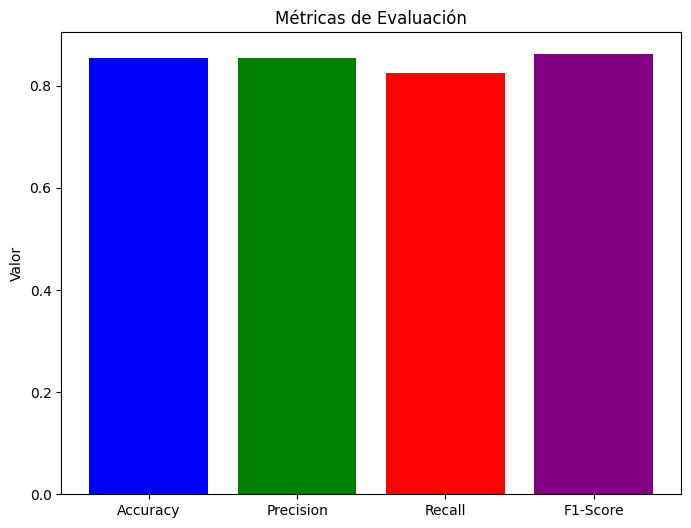

In [ ]:
# Valores de las métricas
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [accuracy, precision, recall, f1]

# Crea una figura de Matplotlib
plt.figure(figsize=(8, 6))

# Crea un gráfico de barras para las métricas
plt.bar(metrics, values, color=['blue', 'green', 'red', 'purple'])

# Etiqueta del eje y
plt.ylabel('Valor')

# Título del gráfico
plt.title('Métricas de Evaluación')

    # Nombre del archivo PDF
pdf_filename2 = "graficaFold2_Metrics.pdf"

plt.savefig(pdf_filename2, format='pdf')

# Muestra el gráfico de barras
plt.show()

# **Matriz de Confusión - Gráfico de Mapa de Calor**


En este bloque de código, se genera un gráfico de mapa de calor para visualizar la matriz de confusión.

- Se crea una figura de Matplotlib con un tamaño de (8, 6).

- La matriz de confusión (`confusion`) se convierte en un DataFrame de Pandas (`confusion_df`) para facilitar la visualización.

- Se utiliza Seaborn para crear un mapa de calor con la función `sns.heatmap()`. Los valores de la matriz de confusión se muestran en las celdas del mapa de calor, y la escala de color (`cmap`) se establece en 'Reds'.

- Se configuran las etiquetas de los ejes x e y, así como el título del mapa de calor.

- El mapa de calor se guarda en un archivo PDF con el nombre `'graficaFold2_Matrix.pdf'`.

- Finalmente, se muestra la matriz de confusión como un mapa de calor.

Este tipo de gráfico proporciona una representación visual efectiva de la distribución de las predicciones del modelo en comparación con las etiquetas reales. Cada celda del mapa de calor muestra la frecuencia con la que una clase predicha coincide con una clase real.

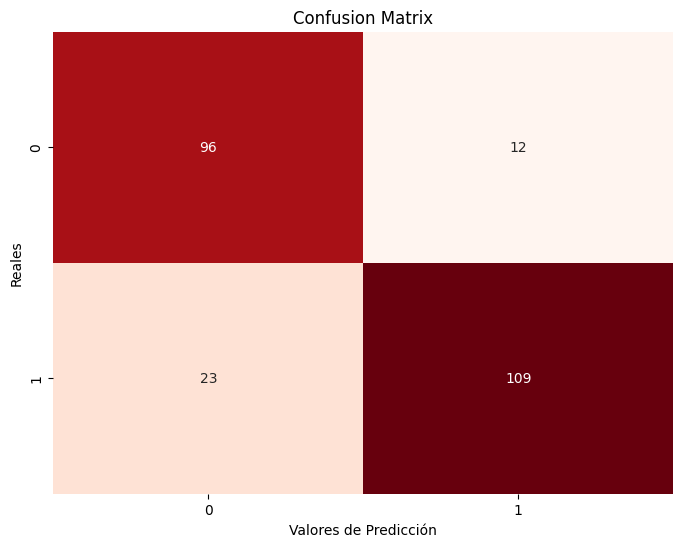

In [ ]:
# Crea una figura de Matplotlib
plt.figure(figsize=(8, 6))

# Convierte la matriz de confusión en un DataFrame de pandas para una mejor visualización
confusion_df = pd.DataFrame(confusion.numpy(), index=range(num_classes), columns=range(num_classes))

# Utiliza Seaborn para crear un mapa de calor
sns.heatmap(confusion_df, annot=True, fmt='g', cmap='Reds', cbar=False)

# Configura etiquetas y títulos
plt.xlabel('Valores de Predicción')
plt.ylabel('Reales')
plt.title('Confusion Matrix')

    # Nombre del archivo PDF
pdf_filename3 = "graficaFold2_Matrix.pdf"

plt.savefig(pdf_filename3, format='pdf')

# Muestra la matriz de confusión
plt.show()